<a href="https://colab.research.google.com/github/uwituzeb/healthcare-facility-planning-capstone-project/blob/main/capstoneNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhancing Health Equity: A data-driven approach for Health Facility Placement in Rwanda


This notebook demonstrates the development of an ML model to support healthcare facility planning. It involves:



*   Visualizing and cleaning geospatial data images
*   Designing a model to classify healthcare facilities from satellite imagery


*   Evaluating model performance







In [ ]:
# install libraries
!pip install earthengine-api geemap rasterio patchify torchvision

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import time
import rasterio
import seaborn as sns
import folium
import geemap.foliumap as geemap
import ee
import os
import torch
from torch.utils.data import Dataset, DataLoader
from patchify import patchify
from torchvision import transforms
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [6]:
# Authenticate and initialize google earth engine
ee.Authenticate()
ee.Initialize(project='rwanda-health-planning')


In [7]:
# Define Rwandan boundaries
Rwanda = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Rwanda'))

In [8]:
# Cloud masking to reduce noise
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band

  Args:
      image (ee.Image): A Sentinel-2 image

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image
  """

  qa = image.select('QA60')
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

In [9]:
# Load sentinel-2 imagery and apply cloud mask
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(Rwanda) \
    .filterDate('2025-01-01', '2025-09-30') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(mask_s2_clouds)

sentinel_median = sentinel2.median().select(['B4','B3','B2','B8','B11','B12']).clip(Rwanda)


In [10]:
print(Rwanda.size().getInfo())

1


In [ ]:
# Visualize map of Rwanda
map_center = Rwanda.geometry().centroid().coordinates().get(0).getInfo(), Rwanda.geometry().centroid().coordinates().get(1).getInfo()
my_map = geemap.Map(center=map_center, zoom=8)
my_map.addLayer(sentinel2, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 RGB')
my_map.addLayerControl()
my_map

In [11]:
# Load ESA World cover for labels
worldcover = ee.Image('ESA/WorldCover/v200/2021').select('Map').clip(Rwanda)


In [12]:
# Export params for both sentinel and label images
region = Rwanda.geometry().bounds().getInfo()['coordinates']

export_params = {
    'image': sentinel_median,
    'description': 'rwanda_sentinel2_2025',
    'scale': 10,
    'region': region,
    'folder': 'earth_engine',
    'maxPixels': 1e13,
    'fileFormat': 'GeoTIFF'
}

export_params_label = {
    'image': worldcover,
    'description': 'rwanda_worldcover_2021',
    'scale': 10,
    'region': region,
    'folder': 'earth_engine',
    'maxPixels': 1e13,
    'fileFormat': 'GeoTIFF'
}

In [ ]:
# Export to Google Drive
task1 = ee.batch.Export.image.toDrive(**export_params)
task2 = ee.batch.Export.image.toDrive(**export_params_label)

task1.start()
print("Exporting to Google Drive...")

print("Monitoring task status...")
while task1.active():
    status = task1.status()
    print(f"Task status: {status['state']}")
    if status['state'] == 'FAILED':
        print(f"Task failed: {status.get('error_message', 'Unknown error')}")
        break
    time.sleep(30)

if task1.status()['state'] == 'COMPLETED':
    print("Export completed successfully!")
else:
    print("Export did not complete successfully.")

Exporting to Google Drive...
Monitoring task status...
Task status: READY
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Task status: RUNNING
Export completed successfully!


In [3]:
sentinel_path = '/content/drive/MyDrive/earth_engine/rwanda_sentinel2_2025-0000000000-0000000000.tif'
label_path = '/content/drive/MyDrive/earth_engine/rwanda_worldcover_2021.tif'

with rasterio.open(sentinel_path) as src:
    s2 = src.read()
    s2_meta = src.meta

with rasterio.open(label_path) as src:
    label = src.read()
    label_meta = src.meta

print(f"Sentinel shape: {s2.shape}, Labels shape: {label.shape}")

# define red, green, blue for visualization
red, green, blue = s2[0], s2[1], s2[2]

# stack into RGB-array for visualization
data = np.dstack((red, green, blue))

Sentinel shape: (3, 13568, 13568), Labels shape: (1, 19954, 22686)


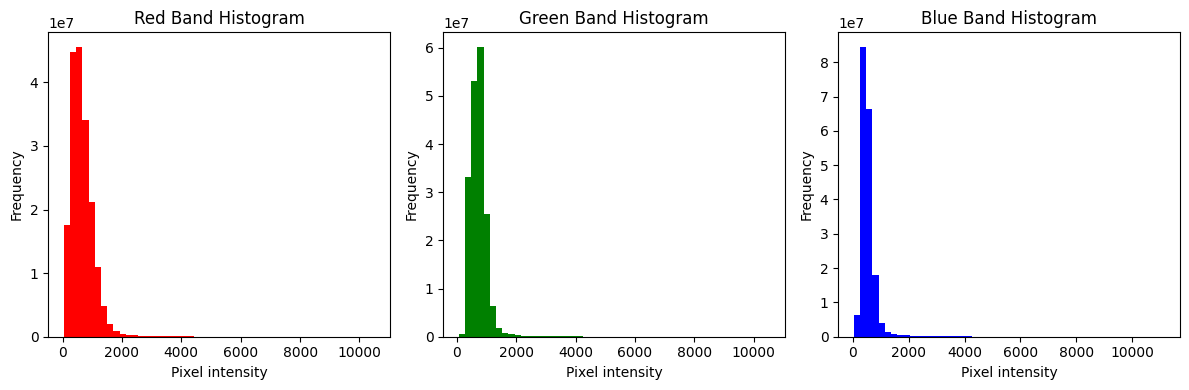

In [ ]:
# Histogram of rgb bands

plt.figure(figsize=(12, 4))
for i, (band, name) in enumerate(zip([red, green, blue], ['Red', 'Green', 'Blue'])):
    plt.subplot(1, 3, i+1)
    plt.hist(band.flatten(), bins=50, color=name.lower())
    plt.title(f'{name} Band Histogram')
    plt.xlabel('Pixel intensity')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [5]:
# Tile sentinel images into patches
patch_size = 256
step = 256
data = np.moveaxis(s2[:3], 0, -1)  # use first 3 bands (RGB)
patches = patchify(data, (patch_size, patch_size, 3), step=step)

print(f"Generated {patches.shape[0]*patches.shape[1]} patches")

Generated 2809 patches


In [7]:
from skimage.transform import resize

# Resize label data to match sentinel data dimensions
labels_resized = resize(label[0], (s2.shape[1], s2.shape[2]), order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)

print(f"Resized labels shape: {labels_resized.shape}")

Resized labels shape: (13568, 13568)


In [8]:
# Assign patch labels
def majority_label(subarr):
    vals, counts = np.unique(subarr, return_counts=True)
    return vals[np.argmax(counts)]

patch_labels = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        patch_label = labels_resized[i*step:i*step+patch_size, j*step:j*step+patch_size]
        patch_labels.append(majority_label(patch_label))

In [9]:
# Prepare features for training
X = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        p = patches[i, j, 0]
        X.append(p.mean(axis=(0,1)))
X = np.array(X)
y = np.array(patch_labels)

In [11]:
# Create binary labels (1 for built-up, 0 otherwise)
y_binary = (y == 50).astype(int)

print(f"Original labels shape: {y.shape}, Binary labels shape: {y_binary.shape}")
print(f"Number of built-up patches: {np.sum(y_binary)}")
print(f"Number of non-built-up patches: {len(y_binary) - np.sum(y_binary)}")

Original labels shape: (2809,), Binary labels shape: (2809,)
Number of built-up patches: 16
Number of non-built-up patches: 2793


In [12]:
# Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Non-built', 'Built-up']))

              precision    recall  f1-score   support

   Non-built       0.99      1.00      1.00       558
    Built-up       0.00      0.00      0.00         4

    accuracy                           0.99       562
   macro avg       0.50      0.50      0.50       562
weighted avg       0.99      0.99      0.99       562

